# 实验二：频域特征迁移

## 加载音频文件

In [2]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from voice_changer.sound import Sound, STFTSpectrogram


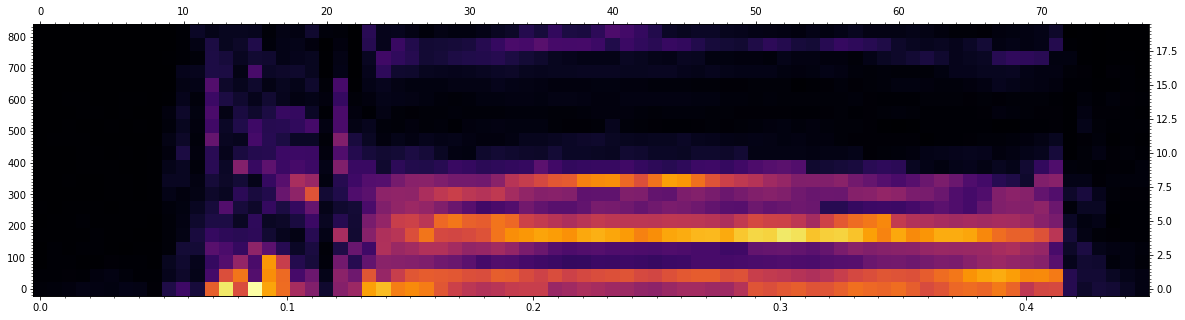

In [11]:
# 男性声音（源）
sound = Sound.from_file("./data/male/ta.aac").cut(1.05, 1.5)
stft_matrix = sound.stft()
nstft = stft_matrix.spectrogram()
mel = sound.melspectrogram()
vol = sound.volume()
f0 = sound.yin()
sound.play()
# 共振峰特性
ffea = sound.formant_features_from(stft_matrix, f0, vol)
plt.figure(figsize=(20, 5))
plt.imshow(ffea.data, aspect="auto", origin="lower", cmap="inferno")
sound.set_axis_by_frames()
plt.show()


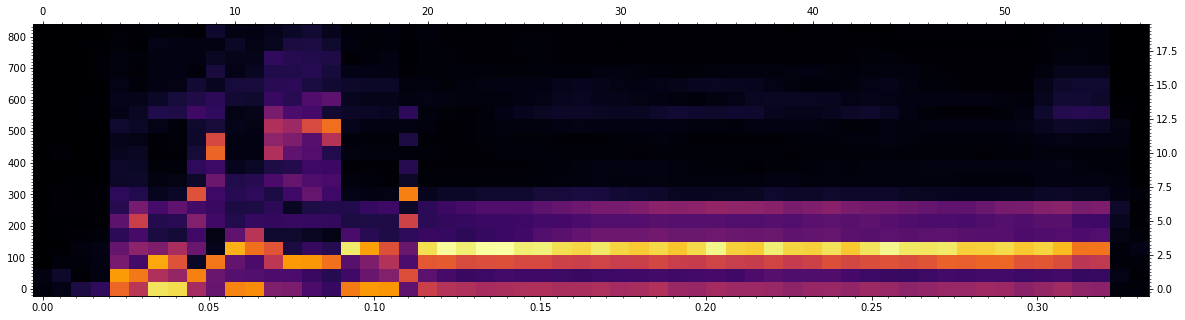

In [12]:
# 女性声音（目标）
snd_j = Sound.from_file('./data/female/ta.wav')
stft_j = snd_j.stft()
nstft_j = stft_matrix.spectrogram()
mel_j = snd_j.melspectrogram()
vol_j = snd_j.volume()
f0_j = snd_j.yin()
snd_j.play()
# 共振峰特性
ffea_j = snd_j.formant_features_from(snd_j.stft(), snd_j.yin(), snd_j.volume())
plt.figure(figsize=(20, 5))
plt.imshow(ffea_j.data, aspect="auto", origin="lower", cmap="inferno")
snd_j.set_axis_by_frames()
plt.show()

## 变调

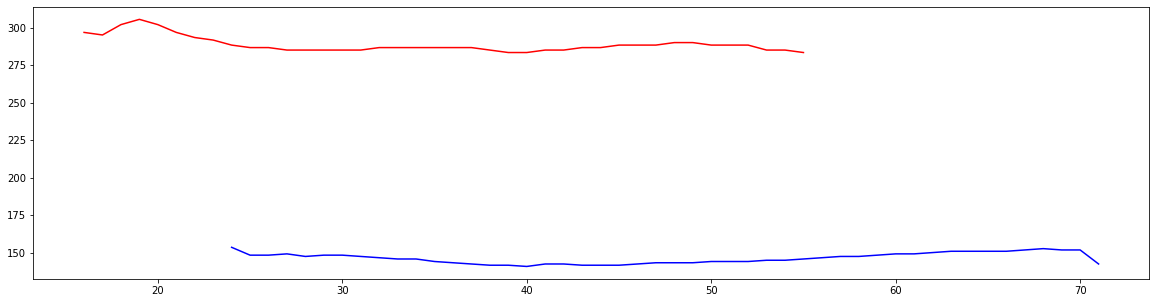

In [13]:
# 分析基音频率
f0_m = sound.yin(pyin=True)
f0_mj = snd_j.yin(pyin=True)
plt.figure(figsize=(20, 5))
plt.plot(f0_m.data, color='b')
plt.plot(f0_mj.data, color='r')
plt.show()


此处使用 pYIN 算法。如果采用原始的 YIN 算法，会因为辅音部分的误差过大，导致基音频率估算错误。

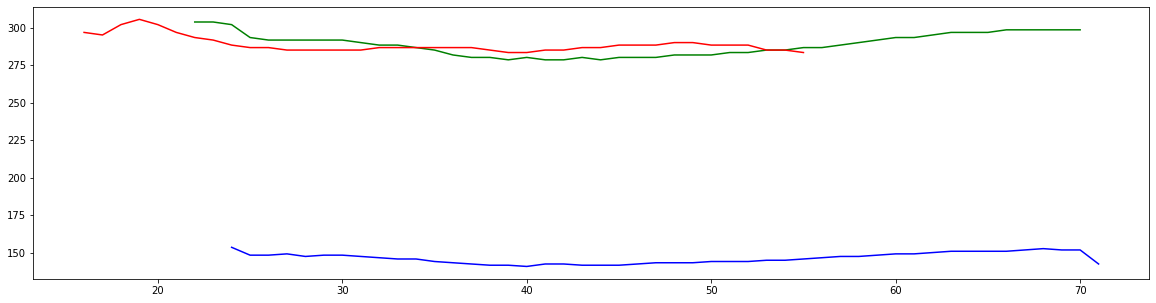

In [14]:
# 变调
rate = np.nanmean(f0_mj.data) / np.nanmean(f0_m.data)
# rate = np.nanmedian(f0_mj.data) / np.nanmedian(f0_m.data)
snd_p = sound.pitch_shift(rate)
for _ in range(4):
    f0_mp = snd_p.yin(pyin=True)    
    rate *= np.nanmean(f0_mj.data) / np.nanmean(f0_mp.data)
    # rate *= np.nanmedian(f0_mj.data) / np.nanmedian(f0_mp.data)
    snd_p = sound.pitch_shift(rate)
snd_p.play()
snd_j.play()
f0_mp = snd_p.yin(pyin=True)
plt.figure(figsize=(20, 5))
plt.plot(f0_m.data, color="b")
plt.plot(f0_mp.data, color="g")
plt.plot(f0_mj.data, color="r")
plt.show()


## 构造滤波器

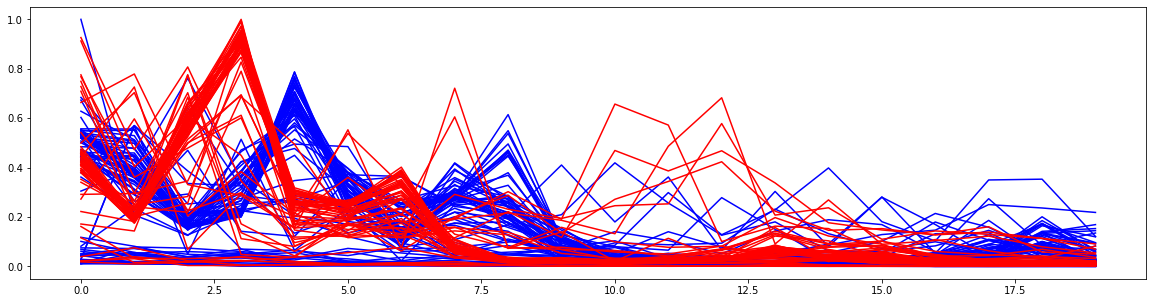

In [15]:
# 分析原始音频的频域特性
ffea_p = snd_p.formant_features()
plt.figure(figsize=(20, 5))
plt.plot(ffea_p.data, color="b")
plt.plot(ffea_j.data, color="r")
plt.show()


蓝线为男性的频域特性，红线为女性的频域特性。可以看出，男性的 F1, F4, F7 较高，而女性的 F0, F3, F4 较高。这是导致两者音色不同的原因。

In [16]:
# 构造滤波器
f0_p = snd_p.yin()
stft_p = snd_p.stft()
feas, length = stft_p.data.shape

# 重采样两组特征到相同长度
ffea_from = ffea_p.resample_to(1024).data
ffea_to = ffea_j.resample_to(1024).data
# 最小二乘法估计滤波器
filt = np.einsum("ij,ij->i", ffea_from, ffea_to) / np.einsum(
    "ij,ij->i", ffea_from, ffea_from
)
fx = np.arange(1, 21).reshape(-1, 1) * f0_p.data * 512 / sound.sr
ff = np.empty((feas, length))
for i in range(length):
    interp = interp1d(
        fx[:, i], filt, bounds_error=False, fill_value=(1, 1), kind="cubic"
    )
    ff[:, i] = interp(np.arange(feas))

for i in range(feas):
    ff[i] = np.convolve(ff[i], np.ones(10) / 10, mode="same")
# 重建音频
nstft_filtered = STFTSpectrogram(stft_p.spectrogram().data * ff)
snd_f = nstft_filtered.griffinlim(sound.sr)
snd_f.play()
snd_j.play()


最小二乘法估计滤波器：

源频域特性$A_{n\times l}$，目标频域特性$B_{n\times l}$，滤波器$H_{n\times 1}$，最小化目标：
$$
\argmin \sum_{i=1}^n \left(A_{ij}H_{j} - B_{ij}\right)^2
$$
解得：
$$
H_j=\frac{\sum_{i=1}^n A_{ij}B_{ij}}{\sum_{i=1}^n A_{ij}^2}
$$

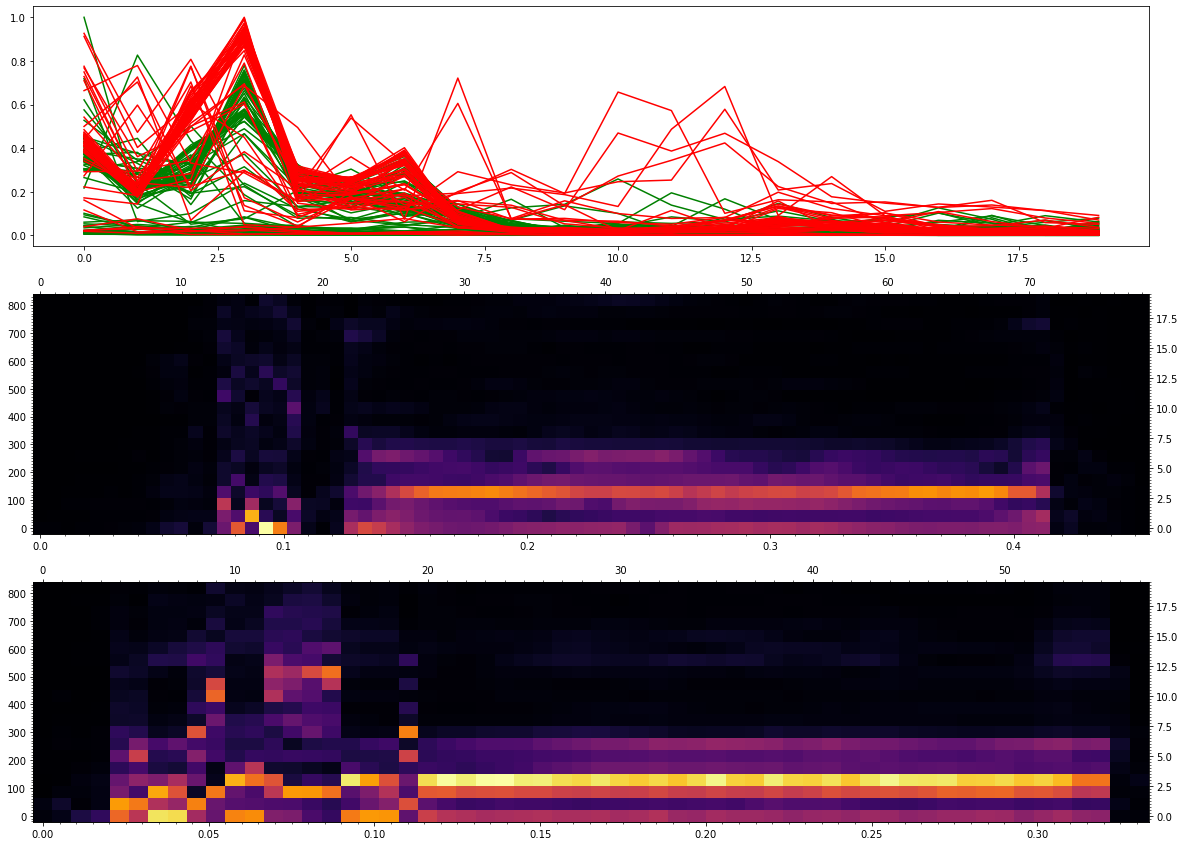

In [9]:
# 观察经过滤波器之后的频域特性
ffea_f = snd_f.formant_features_from(snd_f.stft(), snd_f.yin(), snd_f.volume())
plt.figure(figsize=(20, 15))
plt.subplot(311)
plt.plot(ffea_f.data, color="g")
plt.plot(ffea_j.data, color="r")
plt.subplot(312)
plt.imshow(ffea_f.data, aspect="auto", origin="lower", cmap="inferno")
sound.set_axis_by_frames()
plt.subplot(313)
plt.imshow(ffea_j.data, aspect="auto", origin="lower", cmap="inferno")
sound.set_axis_by_frames()
plt.show()

In [10]:
# 尝试将得到的滤波器应用于其他的语音上
snd_p_ano = Sound.from_file("./data/test/aiueo.aac").pitch_shift(rate)
f0_p_ano = snd_p_ano.yin()
stft_p_ano = snd_p_ano.stft()
nstft_p_ano = stft_p_ano.spectrogram()
feas, length = stft_p_ano.data.shape

fx = np.arange(1, 21).reshape(-1, 1) * f0_p_ano.data * 512 / sound.sr
ff = np.empty((feas, length))
for i in range(length):
    interp = interp1d(
        fx[:, i], filt, bounds_error=False, fill_value=(1, 1), kind="cubic"
    )
    ff[:, i] = interp(np.arange(feas))

for i in range(feas):
    ff[i] = np.convolve(ff[i], np.ones(10) / 10, mode="same")
# snd_p_ano.play()
STFTSpectrogram(nstft_p_ano.data * ff).griffinlim(sound.sr).play()


效果并不是很好。原因在于得到的滤波器只是对于某一个音节的建模，泛用性较差。

同时，此方法对于有音调的语音也不适用。音调会导致频域特征随时间改变，无法找到一个准确的滤波器。